In [56]:
from rembg import remove
import os
import random
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw
from pycocotools import mask
from skimage import measure
import json

In [57]:
#define paths
imagesObjectsPath = "imagesObjects/"
croppedPath  = "images_cropped/"
fg_folders = [
    ("coca/","cocacola" ),
]
bg_folder = "images_bg/"
output_folder = "dataset/"
fg_folders



[('coca/', 'cocacola')]

In [58]:
#remuevo Fondo verde
for folder in fg_folders:
    for filename in os.listdir(f"{imagesObjectsPath}{folder[0]}"):
        myImage = Image.open(f"{imagesObjectsPath}{folder[0]}{filename}")
        myCroppedImage=remove(myImage) 
        myCroppedImage.save(f"{imagesObjectsPath}{folder[0]}{filename}")
       

In [59]:
#recorto imagenes
for folder in fg_folders:
    for filename in os.listdir(f"{imagesObjectsPath}{folder[0]}"):
        try:
            myImage = Image.open(f"{imagesObjectsPath}{folder[0]}{filename}")
            black = Image.new('RGBA', myImage.size)
            myImage = Image.composite(myImage, black, myImage)
            myCroppedImage = myImage.crop(myImage.getbbox())
            myCroppedImage.save(f"{croppedPath}{folder[0]}{filename}")
        except:
            continue

In [60]:
objects_list = ["cocacola"]
annotations_ID = {}
categories = []
for i, object in enumerate(objects_list):
    annotations_ID[object] = i
    categories.append({"id": i, "name": object})

print(annotations_ID)
print(categories)


{'cocacola': 0}
[{'id': 0, 'name': 'cocacola'}]


In [61]:
# Load the list of files in each of the three folders
fg_files = {}
for folder, category in fg_folders:
    fg_files[category] = os.listdir(f"{croppedPath}{folder}")

fg_files

{'cocacola': ['_0.png',
  '_1.png',
  '_2.png',
  '_3.png',
  '_4.png',
  '_5.png',
  '_6.png',
  '_7.png',
  '_8.png',
  '_9.png']}

In [71]:
# Declare two empty list that will help as storage for the images and annotations of the dataset
images=[]
annotations=[]
annotations2=[]
#Declare in 0 the img id and annotation id
img_id=int(0)
anno_id=int(0)

In [62]:
#ATENTION The next code will ONLY generate one image, if you want to generate more images
#You neet to put the next blocks of code into a for

In [63]:
#select hramdomly how many objects will be in an image
num_objects = random.randint(0, 1)
print("number of objects",num_objects)

number of objects 1


In [64]:
# Select randomly the categories that will bve in an image
fg_categories = random.choices(objects_list, k=num_objects)
fg_categories

['cocacola']

In [65]:
# Select randomly the image for each category
fg_files_selected = []
for category in fg_categories:
    fg_files_selected.append([category,random.choice(fg_files[category])])
print(fg_files_selected)

[['cocacola', '_5.png']]


In [67]:
# Load the selected foreground images using Pillow
fg_imgs = []
for img in fg_files_selected:
    folder = (f"{croppedPath}{[f[0] for f in fg_folders if f[1] == img[0]][0]}")
    fg_imgs.append([img[0],Image.open(folder + img[1]),folder+img[1]])
fg_imgs

[['cocacola',
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=305x411>,
  'images_cropped/coca/_5.png']]

In [68]:
# Randomly resize and rotate the foreground images using Pillow's transform module
for img in fg_imgs:
    fg_img=img[1]
    angle = random.randint(-5, 5)
    scale = random.uniform(0.5, 1)

    fg_img = fg_img.rotate(angle, resample=Image.BICUBIC, expand=True)
    fg_img = fg_img.resize((int(fg_img.width * scale), int(fg_img.height * scale)))

    img[1] = fg_img

In [69]:
#change bluur randomly
for img in fg_imgs:
    fg_img=img[1]
    blur_intensity = random.uniform(0, 1.0)*0.01
    kernel_size = (2 * round(blur_intensity * 20) + 1, 2 * round(blur_intensity * 20) + 1)
    fg_arr = np.array(fg_img)
    fg_arr = cv2.GaussianBlur(fg_arr, kernel_size, 0)
    img[1] = Image.fromarray(fg_arr)

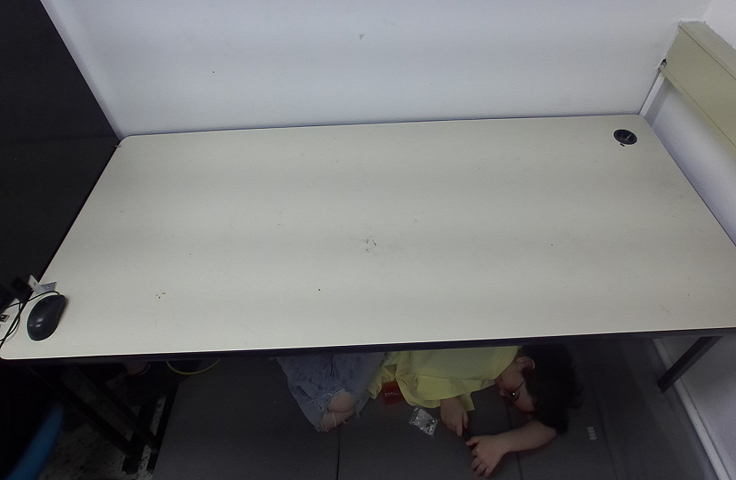

In [78]:
# Load a ramdom background image using Pillow
bg_files = os.listdir(bg_folder)
bg_file = random.choice(bg_files)
bg_img = Image.open(bg_folder + bg_file)
bg_img

x=441
y=87


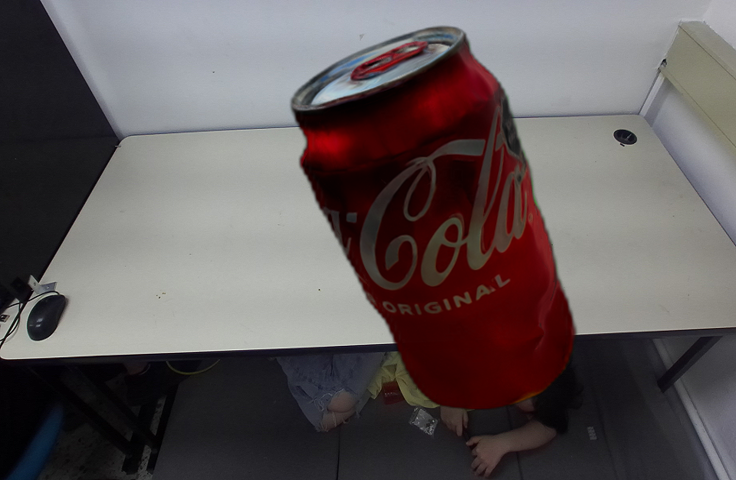

In [79]:
# Define the maximum overlap as a percentage
max_overlap_pct = 10

# Define an array to keep track of occupied areas
occupied = np.zeros((bg_img.height, bg_img.width))

for img in fg_imgs:
    fg_img=img[1]

    #Calculate the maximum overlap area
    max_overlap_area = (fg_img.width * fg_img.height) * (max_overlap_pct / 100)

    seg_img = img[1]
    
    
    
    # Convert the image to a NumPy array
    img_arr = np.array(seg_img)
    
    # Create a binary mask of the non-transparent pixels
    mask = img_arr[:, :, 3] != 0

    # Convert the mask to a COCO format segmentation
    segmentation = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                segmentation.append(j)
                segmentation.append(i)
    segmentation = [segmentation]

    # Calculate the area of the segmentation
    area = 0
    for i in range(len(segmentation[0]) // 2):
        x1 = segmentation[0][2 * i]
        y1 = segmentation[0][2 * i + 1]
        x2 = segmentation[0][(2 * i + 2) % len(segmentation[0])]
        y2 = segmentation[0][(2 * i + 3) % len(segmentation[0])]
        area += x1 * y2 - x2 * y1
    area = abs(area) / 2

    # Calculate the maximum allowed position for the top-left corner
    max_x = bg_img.width - fg_img.width
    max_y = bg_img.height - fg_img.height
    max_area = fg_img.width * fg_img.height
    print(f"x={max_x}")
    print(f"y={max_y}")


    # Generate a random location until an unoccupied area is found that meets the overlap limit

    total_area = bg_img.width * bg_img.height
    overlap_area = total_area


    for i in range (10):
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # Calculate the overlap area
        overlap_area = np.sum(occupied[y:y+fg_img.height, x:x+fg_img.width])

        # Check if the area is unoccupied and the overlap limit is not exceeded
        if (max_overlap_area - max_area) >= np.sum(occupied):
            break
        if i==10:
            continue
    #Update the segmentation cordinates with the position

    for i in range(0, len(segmentation[0])):
        if i % 2:
            segmentation[0][i]=int(segmentation[0][i]+y)
        else :
            segmentation[0][i]=int(segmentation[0][i]+x)
    
    # Update the occupied array
    occupied[y:y+fg_img.height, x:x+fg_img.width] = 1
    
    #paste the object in the background image
    bg_img.paste(fg_img, (x, y), fg_img)

    #add the annotation to the annotations list
    annotations.append({"id": anno_id,"image_id": img_id,"category_id": annotations_ID[img[0]],"bbox": [x, y, fg_img.width, fg_img.height],"segmentation": segmentation,"area": area,"iscrowd": 0})
    #Increment anno_id
    anno_id=anno_id+1

#Increment img_id
img_id=img_id+1
bg_img

In [73]:
# Define the COCO dictionary
coco_dict = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

In [74]:
coco_dict2 = {
    "images": images,
    "annotations": annotations2,
    "categories": categories
}

In [75]:
coco_dict2
# Convert the dictionary to a JSON string
json_string = json.dumps(coco_dict2)

# Write the JSON string to a file
with open("annotations_val_seg.json", 'w') as f:
    f.write(json_string)

In [76]:
coco_dict
# Convert the dictionary to a JSON string
json_string = json.dumps(coco_dict)

# Write the JSON string to a file
with open("annotations_val.json", 'w') as f:
    f.write(json_string)